# KKBox Customer Segmentation Analysis
### w/ BigQuery and Apache Spark

---

# Part 1.A: <font color=green>*K-Means Model Creation and Evaluation*</font>

---

In [5]:
# General Imports
from __future__ import absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from scipy import stats
import time
import warnings
warnings.filterwarnings('ignore')

# Evaluation Imports
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from scipy import stats

# Imports for PySpark
import findspark
findspark.init('C:\spark\spark-2.4.4-bin-hadoop2.7')
# import pyspark
from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext

# # Imports for BigQuery connection
# import json
# import pprint
# import subprocess

# # Imports for GCP
# from google.cloud import bigquery
import time 
# import gcsfs

# Imports for Spark ML
from pyspark.ml.feature import (VectorAssembler, OneHotEncoderEstimator, OneHotEncoder)
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
## Dataproc Specs

# Jupyter Initialization: gs://srcd-dataproc/jupyter.sh 
# Components Installed: Anaconda and Jupyter
# Master Node:   x1 - 4 vCPU w/ 15 GB RAM each
# Workers Nodes: x5 - 4 vCPU w/ 15 GB RAM each
# Disk: 100GB

## Create Spark Session and Import Data

In [ ]:
# Specify Google Credentials
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='D:\OneDrive\J-5\GitHub\Google Credentials.json'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.Builder().config(conf=SparkConf().setMaster("local[*]")).getOrCreate()

# Instantiate BigQuery magic
# %load_ext google.cloud.bigquery

In [3]:
# # If Working Locally on Computer, Importing Data Locally#

# Import DRV_Jan2016 (Train Set) 

DRV_Jan20160 = spark.read.csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Jan2016000000000000',inferSchema=True,header=True)
DRV_Jan20161 = spark.read.csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Jan2016000000000001',inferSchema=True,header=True)
DRV_Jan20162 = spark.read.csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Jan2016000000000002',inferSchema=True,header=True)

DRV_Jan2016 = DRV_Jan20160.union(DRV_Jan20161)
DRV_Jan2016 = DRV_Jan2016.union(DRV_Jan20162)

DRV_Jan20160.unpersist()
DRV_Jan20161.unpersist()
DRV_Jan20162.unpersist()

# Import DRV_Feb2016 (Validation Set) 
DRV_Feb20160 = spark.read.csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Feb2016000000000000',inferSchema=True,header=True)
DRV_Feb20161 = spark.read.csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Feb2016000000000001',inferSchema=True,header=True)
DRV_Feb20162 = spark.read.csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Feb2016000000000002',inferSchema=True,header=True)

DRV_Feb2016 = DRV_Feb20160.union(DRV_Feb20161)
DRV_Feb2016 = DRV_Feb2016.union(DRV_Feb20162)

DRV_Feb20160.unpersist()
DRV_Feb20161.unpersist()
DRV_Feb20162.unpersist()

DataFrame[msno: string, membership_expire_date: timestamp, payment_method_id: int, payment_plan_days: int, plan_list_price: int, net_paid_amount: int, is_net_paid_amount: string, is_auto_renew: int, is_cancel: int, city: int, bd: int, registered_via: int, registration_init_time: timestamp, membership_length: int, is_churn: int, total_songs: int, total_logins: int, total_secs: double, sum_num_unq: int, sum_num_repeat: int, sum_over_50pec: int, sum_over_75pec: int, sum_over_985pec: int, total_transactions: int, total_spent: int, avg_spent_trans: double, spent_per_logins: double, spent_per_secs: double, spent_per_song: double, spent_per_num_unq: double, spent_per_num_repeats: double, never_active_subscriber: int, total_spent_zero: int, city_agg: int, payment_method_agg: int, expire_last_login: int, total_cancelations: int, songs_last_7: int, songs_last_7_AVG: double, logins_last_7: int, logins_last_7_AVG: double, total_secs_last_7: double, total_secs_last_7_AVG: double, num_unq_last_7: in

In [24]:
# Import DRV_Jan2016 as Pandas 
DRV_Jan20160 = pd.read_csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Jan2016000000000000')
DRV_Jan20161 = pd.read_csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Jan2016000000000001')
DRV_Jan20162 = pd.read_csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Jan2016000000000002')

DRV_Jan2016x = pd.concat([DRV_Jan20160,DRV_Jan20161,DRV_Jan20162])

del DRV_Jan20160
del DRV_Jan20161
del DRV_Jan20162

In [ ]:
# # If Working on Dataproc Cloud ##

# # Import DRV_Jan2016 (Train Set) 
# DRV_Jan2016_1to1 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Jan2016_1to1',inferSchema=True,header=True)
# DRV_Jan2016_3to1 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Jan2016_3to1',inferSchema=True,header=True)
# DRV_Jan2016_5to1 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Jan2016_5to1',inferSchema=True,header=True)
# DRV_Jan2016_7to1 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Jan2016_7to1',inferSchema=True,header=True)
# DRV_Jan2016_9to1 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Jan2016_9to1',inferSchema=True,header=True)
# DRV_Jan2016_11to1 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Jan2016_11to1',inferSchema=True,header=True)
# DRV_Jan2016_13to1 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Jan2016_13to1',inferSchema=True,header=True)

# DRV_Jan20160 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Jan2016000000000000',inferSchema=True,header=True)
# DRV_Jan20161 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Jan2016000000000001',inferSchema=True,header=True)
# DRV_Jan20162 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Jan2016000000000002',inferSchema=True,header=True)

# DRV_Jan2016 = DRV_Jan20160.union(DRV_Jan20161)
# DRV_Jan2016 = DRV_Jan2016.union(DRV_Jan20162)

# DRV_Jan20160 = None
# DRV_Jan20161 = None
# DRV_Jan20162 = None

# # Import DRV_Feb2016 (Validation Set) 
# DRV_Feb20160 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Feb2016000000000000',inferSchema=True,header=True)
# DRV_Feb20161 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Feb2016000000000001',inferSchema=True,header=True)
# DRV_Feb20162 = spark.read.csv('gs://dataproc-fb3fa26d-011a-4757-afb9-5efdd6e75d60-us-east1/Datasets/KKBox User Data/Monthly Datasets/DRV_Feb2016000000000002',inferSchema=True,header=True)

# DRV_Feb2016 = DRV_Feb20160.union(DRV_Feb20161)
# DRV_Feb2016 = DRV_Feb2016.union(DRV_Feb20162)

# DRV_Feb20160 = None
# DRV_Feb20161 = None
# DRV_Feb20162 = None

***Cast Correct Column Types on All Sets***

In [ ]:
column_types_pd = [('msno', 'STRING'),
 ('membership_expire_date', 'DATE'),
 ('payment_method_id', 'INT64'),
 ('payment_plan_days', 'INT64'),
 ('plan_list_price', 'INT64'),
 ('net_paid_amount', 'INT64'),
 ('is_net_paid_amount', 'STRING'),
 ('is_auto_renew', 'INT64'),
 ('city', 'INT64'),
 ('bd', 'INT64'),
 ('registered_via', 'INT64'),
 ('registration_init_time', 'DATE'),
 ('membership_length', 'INT64'),
 ('is_churn', 'FLOAT64'),
 ('total_songs', 'INT64'),
 ('total_logins', 'INT64'),
 ('total_secs', 'FLOAT64'),
 ('sum_num_unq', 'INT64'),
 ('sum_num_repeat', 'INT64'),
 ('sum_over_50pec', 'INT64'),
 ('sum_over_75pec', 'INT64'),
 ('sum_over_985pec', 'INT64'),
 ('total_transactions', 'INT64'),
 ('total_spent', 'FLOAT64'),
 ('avg_spent_trans', 'FLOAT64'),
 ('spent_per_logins', 'FLOAT64'),
 ('spent_per_secs', 'FLOAT64'),
 ('spent_per_song', 'FLOAT64'),
 ('spent_per_num_unq', 'FLOAT64'),
 ('spent_per_num_repeats', 'FLOAT64'),
 ('never_active_subscriber', 'FLOAT64'),
 ('total_spent_zero', 'FLOAT64'),
 ('city_agg', 'INT64'),
 ('payment_method_agg', 'INT64'),
 ('songs_last_7', 'FLOAT64'),
 ('songs_last_7_AVG', 'FLOAT64'),
 ('logins_last_7', 'FLOAT64'),
 ('logins_last_7_AVG', 'FLOAT64'),
 ('total_secs_last_7', 'FLOAT64'),
 ('total_secs_last_7_AVG', 'FLOAT64'),
 ('num_unq_last_7', 'FLOAT64'),
 ('num_unq_last_7_AVG', 'FLOAT64'),
 ('num_repeat_last_7', 'FLOAT64'),
 ('num_repeat_last_7_AVG', 'FLOAT64'),
 ('over_50perc_last_7', 'FLOAT64'),
 ('over_50perc_last_7_AVG', 'FLOAT64'),
 ('over_75perc_last_7', 'FLOAT64'),
 ('over_75perc_last_7_AVG', 'FLOAT64'),
 ('over_985perc_last_7', 'FLOAT64'),
 ('over_985perc_last_7_AVG', 'FLOAT64'),
 ('songs_last_15', 'FLOAT64'),
 ('songs_last_15_AVG', 'FLOAT64'),
 ('logins_last_15', 'FLOAT64'),
 ('logins_last_15_AVG', 'FLOAT64'),
 ('total_secs_last_15', 'FLOAT64'),
 ('total_secs_last_15_AVG', 'FLOAT64'),
 ('num_unq_last_15', 'FLOAT64'),
 ('num_unq_last_15_AVG', 'FLOAT64'),
 ('num_repeat_last_15', 'FLOAT64'),
 ('num_repeat_last_15_AVG', 'FLOAT64'),
 ('over_50perc_last_15', 'FLOAT64'),
 ('over_50perc_last_15_AVG', 'FLOAT64'),
 ('over_75perc_last_15', 'FLOAT64'),
 ('over_75perc_last_15_AVG', 'FLOAT64'),
 ('over_985perc_last_15', 'FLOAT64'),
 ('over_985perc_last_15_AVG', 'FLOAT64'),
 ('songs_last_30', 'FLOAT64'),
 ('songs_last_30_AVG', 'FLOAT64'),
 ('logins_last_30', 'FLOAT64'),
 ('logins_last_30_AVG', 'FLOAT64'),
 ('total_secs_last_30', 'FLOAT64'),
 ('total_secs_last_30_AVG', 'FLOAT64'),
 ('num_unq_last_30', 'FLOAT64'),
 ('num_unq_last_30_AVG', 'FLOAT64'),
 ('num_repeat_last_30', 'FLOAT64'),
 ('num_repeat_last_30_AVG', 'FLOAT64'),
 ('over_50perc_last_30', 'FLOAT64'),
 ('over_50perc_last_30_AVG', 'FLOAT64'),
 ('over_75perc_last_30', 'FLOAT64'),
 ('over_75perc_last_30_AVG', 'FLOAT64'),
 ('over_985perc_last_30', 'FLOAT64'),
 ('over_985perc_last_30_AVG', 'FLOAT64'),
 ('songs_last_60', 'FLOAT64'),
 ('songs_last_60_AVG', 'FLOAT64'),
 ('logins_last_60', 'FLOAT64'),
 ('logins_last_60_AVG', 'FLOAT64'),
 ('total_secs_last_60', 'FLOAT64'),
 ('total_secs_last_60_AVG', 'FLOAT64'),
 ('num_unq_last_60', 'FLOAT64'),
 ('num_unq_last_60_AVG', 'FLOAT64'),
 ('num_repeat_last_60', 'FLOAT64'),
 ('num_repeat_last_60_AVG', 'FLOAT64'),
 ('over_50perc_last_60', 'FLOAT64'),
 ('over_50perc_last_60_AVG', 'FLOAT64'),
 ('over_75perc_last_60', 'FLOAT64'),
 ('over_75perc_last_60_AVG', 'FLOAT64'),
 ('over_985perc_last_60', 'FLOAT64'),
 ('over_985perc_last_60_AVG', 'FLOAT64'),
 ('songs_last_120', 'FLOAT64'),
 ('songs_last_120_AVG', 'FLOAT64'),
 ('logins_last_120', 'FLOAT64'),
 ('logins_last_120_AVG', 'FLOAT64'),
 ('total_secs_last_120', 'FLOAT64'),
 ('total_secs_last_120_AVG', 'FLOAT64'),
 ('num_unq_last_120', 'FLOAT64'),
 ('num_unq_last_120_AVG', 'FLOAT64'),
 ('num_repeat_last_120', 'FLOAT64'),
 ('num_repeat_last_120_AVG', 'FLOAT64'),
 ('over_50perc_last_120', 'FLOAT64'),
 ('over_50perc_last_120_AVG', 'FLOAT64'),
 ('over_75perc_last_120', 'FLOAT64'),
 ('over_75perc_last_120_AVG', 'FLOAT64'),
 ('over_985perc_last_120', 'FLOAT64'),
 ('over_985perc_last_120_AVG', 'FLOAT64'),
 ('SUM_unq_songs_0_15', 'FLOAT64'),
 ('AVG_unq_songs_0_15', 'FLOAT64'),
 ('SUM_songs_0_15', 'FLOAT64'),
 ('AVG_songs_0_15', 'FLOAT64'),
 ('SUM_secs_0_15', 'FLOAT64'),
 ('AVG_secs_0_15', 'FLOAT64'),
 ('SUM_songs50_0_15', 'FLOAT64'),
 ('AVG_songs50_0_15', 'FLOAT64'),
 ('SUM_logins_0_15', 'FLOAT64'),
 ('AVG_logins_0_15', 'FLOAT64'),
 ('SUM_repeats_0_15', 'FLOAT64'),
 ('AVG_repeats_0_15', 'FLOAT64'),
 ('SUM_unq_songs_15_30', 'FLOAT64'),
 ('AVG_unq_songs_15_30', 'FLOAT64'),
 ('SUM_songs_15_30', 'FLOAT64'),
 ('AVG_songs_15_30', 'FLOAT64'),
 ('SUM_secs_15_30', 'FLOAT64'),
 ('AVG_secs_15_30', 'FLOAT64'),
 ('SUM_songs50_15_30', 'FLOAT64'),
 ('AVG_songs50_15_30', 'FLOAT64'),
 ('SUM_logins_15_30', 'FLOAT64'),
 ('AVG_logins_15_30', 'FLOAT64'),
 ('SUM_repeats_15_30', 'FLOAT64'),
 ('AVG_repeats_15_30', 'FLOAT64'),
 ('SUM_unq_songs_30_45', 'FLOAT64'),
 ('AVG_unq_songs_30_45', 'FLOAT64'),
 ('SUM_songs_30_45', 'FLOAT64'),
 ('AVG_songs_30_45', 'FLOAT64'),
 ('SUM_secs_30_45', 'FLOAT64'),
 ('AVG_secs_30_45', 'FLOAT64'),
 ('SUM_songs50_30_45', 'FLOAT64'),
 ('AVG_songs50_30_45', 'FLOAT64'),
 ('SUM_logins_30_45', 'FLOAT64'),
 ('AVG_logins_30_45', 'FLOAT64'),
 ('SUM_repeats_30_45', 'FLOAT64'),
 ('AVG_repeats_30_45', 'FLOAT64'),
 ('SUM_unq_songs_45_60', 'FLOAT64'),
 ('AVG_unq_songs_45_60', 'FLOAT64'),
 ('SUM_songs_45_60', 'FLOAT64'),
 ('AVG_songs_45_60', 'FLOAT64'),
 ('SUM_secs_45_60', 'FLOAT64'),
 ('AVG_secs_45_60', 'FLOAT64'),
 ('SUM_songs50_45_60', 'FLOAT64'),
 ('AVG_songs50_45_60', 'FLOAT64'),
 ('SUM_logins_45_60', 'FLOAT64'),
 ('AVG_logins_45_60', 'FLOAT64'),
 ('SUM_repeats_45_60', 'FLOAT64'),
 ('AVG_repeats_45_60', 'FLOAT64'),
 ('DIFSUM_unq_songs_0_15_15_30', 'FLOAT64'),
 ('DIFAVG_unq_songs_0_15_15_30', 'FLOAT64'),
 ('DIFSUM_songs_0_15_15_30', 'FLOAT64'),
 ('DIFAVG_songs_0_15_15_30', 'FLOAT64'),
 ('DIFSUM_secs_0_15_15_30', 'FLOAT64'),
 ('DIFAVG_secs_0_15_15_30', 'FLOAT64'),
 ('DIFSUM_songs50_0_15_15_30', 'FLOAT64'),
 ('DIFAVG_songs50_0_15_15_30', 'FLOAT64'),
 ('DIFSUM_logins_0_15_15_30', 'FLOAT64'),
 ('DIFAVG_logins_0_15_15_30', 'FLOAT64'),
 ('DIFSUM_repeats_0_15_15_30', 'FLOAT64'),
 ('DIFAVG_repeats_0_15_15_30', 'FLOAT64'),
 ('DIFSUM_unq_songs_15_30_30_45', 'FLOAT64'),
 ('DIFAVG_unq_songs_15_30_30_45', 'FLOAT64'),
 ('DIFSUM_songs_15_30_30_45', 'FLOAT64'),
 ('DIFAVG_songs_15_30_30_45', 'FLOAT64'),
 ('DIFSUM_secs_15_30_30_45', 'FLOAT64'),
 ('DIFAVG_secs_15_30_30_45', 'FLOAT64'),
 ('DIFSUM_songs50_15_30_30_45', 'FLOAT64'),
 ('DIFAVG_songs50_15_30_30_45', 'FLOAT64'),
 ('DIFSUM_logins_15_30_30_45', 'FLOAT64'),
 ('DIFAVG_logins_15_30_30_45', 'FLOAT64'),
 ('DIFSUM_repeats_15_30_30_45', 'FLOAT64'),
 ('DIFAVG_repeats_15_30_30_45', 'FLOAT64'),
 ('DIFSUM_unq_songs_30_45_45_60', 'FLOAT64'),
 ('DIFAVG_unq_songs_30_45_45_60', 'FLOAT64'),
 ('DIFSUM_songs_30_45_45_60', 'FLOAT64'),
 ('DIFAVG_songs_30_45_45_60', 'FLOAT64'),
 ('DIFSUM_secs_30_45_45_60', 'FLOAT64'),
 ('DIFAVG_secs_30_45_45_60', 'FLOAT64'),
 ('DIFSUM_songs50_30_45_45_60', 'FLOAT64'),
 ('DIFAVG_songs50_30_45_45_60', 'FLOAT64'),
 ('DIFSUM_logins_30_45_45_60', 'FLOAT64'),
 ('DIFAVG_logins_30_45_45_60', 'FLOAT64'),
 ('DIFSUM_repeats_30_45_45_60', 'FLOAT64'),
 ('DIFAVG_repeats_30_45_45_60', 'FLOAT64'),
 ('expire_last_login', 'INT64'),
 ('total_cancelations', 'INT64'),
 ('login_after_expire_10', 'INT64'),
 ('login_after_expire_20', 'INT64'),
 ('login_after_expire_30', 'INT64'),
 ('STD_unq_songs_0_15', 'FLOAT64'),
 ('STD_songs_0_15', 'FLOAT64'),
 ('STD_secs_0_15', 'FLOAT64'),
 ('STD_songs50_0_15', 'FLOAT64'),
 ('STD_repeats_0_15', 'FLOAT64'),
 ('STD_unq_songs_15_30', 'FLOAT64'),
 ('STD_songs_15_30', 'FLOAT64'),
 ('STD_secs_15_30', 'FLOAT64'),
 ('STD_songs50_15_30', 'FLOAT64'),
 ('STD_repeats_15_30', 'FLOAT64'),
 ('STD_unq_songs_30_45', 'FLOAT64'),
 ('STD_songs_30_45', 'FLOAT64'),
 ('STD_secs_30_45', 'FLOAT64'),
 ('STD_songs50_30_45', 'FLOAT64'),
 ('STD_repeats_30_45', 'FLOAT64'),
 ('STD_unq_songs_45_60', 'FLOAT64'),
 ('STD_songs_45_60', 'FLOAT64'),
 ('STD_secs_45_60', 'FLOAT64'),
 ('STD_songs50_45_60', 'FLOAT64'),
 ('STD_repeats_45_60', 'FLOAT64'),
 ('DIFSTD_unq_songs_0_15_15_30', 'FLOAT64'),
 ('DIFSTD_songs_0_15_15_30', 'FLOAT64'),
 ('DIFSTD_secs_0_15_15_30', 'FLOAT64'),
 ('DIFSTD_songs50_0_15_15_30', 'FLOAT64'),
 ('DIFSTD_repeats_0_15_15_30', 'FLOAT64'),
 ('DIFSTD_unq_songs_15_30_30_45', 'FLOAT64'),
 ('DIFSTD_songs_15_30_30_45', 'FLOAT64'),
 ('DIFSTD_secs_15_30_30_45', 'FLOAT64'),
 ('DIFSTD_songs50_15_30_30_45', 'FLOAT64'),
 ('DIFSTD_repeats_15_30_30_45', 'FLOAT64'),
 ('DIFSTD_unq_songs_30_45_45_60', 'FLOAT64'),
 ('DIFSTD_songs_30_45_45_60', 'FLOAT64'),
 ('DIFSTD_secs_30_45_45_60', 'FLOAT64'),
 ('DIFSTD_songs50_30_45_45_60', 'FLOAT64'),
 ('DIFSTD_repeats_30_45_45_60', 'FLOAT64'),
 ('is_cancel', 'INT64')]

In [ ]:
from pyspark.sql.functions import expr

# Correctly Cast DRV_Feb2016
for feature, datatype in column_types_pd:
    if datatype == 'STRING':
        exec(f'DRV_Jan2016_1to1 = DRV_Feb2016.withColumn("{feature}", expr("CAST({feature} AS string)"))')
    if datatype == 'DATE':
        exec(f'DRV_Jan2016_1to1 = DRV_Feb2016.withColumn("{feature}", expr("CAST({feature} AS timestamp)"))')
    if datatype == 'INT64':
        exec(f'DRV_Jan2016_1to1 = DRV_Feb2016.withColumn("{feature}", expr("CAST({feature} AS integer)"))')
    if datatype == 'FLOAT64':
        exec(f'DRV_Jan2016_1to1 = DRV_Feb2016.withColumn("{feature}", expr("CAST({feature} AS double)"))')

## Model Pre-Processing
https://medium.com/@dhiraj.p.rai/essentials-of-feature-engineering-in-pyspark-part-i-76a57680a85

### - <font color=blue>Split Feautres by Categorical or Continuous</font> -

In [4]:
# Create list of Categorical feature names
cat_feats = ['is_auto_renew', 'total_spent_zero', 'city_agg', 'payment_method_agg', 'never_active_subscriber']

In [5]:
# Create list of Continuous feature names
cont_feats = [x for x in DRV_Jan2016.columns if x not in cat_feats]
cont_feats.remove('msno')
cont_feats.remove('is_churn')
cont_feats.remove('membership_expire_date')
cont_feats.remove('registration_init_time')
cont_feats.remove('city')
cont_feats.remove('bd')
cont_feats.remove('payment_method_id')
cont_feats.remove('is_net_paid_amount')
cont_feats.remove('registered_via')

### - <font color=blue>Data Pre-Processing</font> -

#### <font color=purple>*Vector Assembler*</font>

In [6]:
# Create master list of feature names for model
final_features = cont_feats

In [7]:
# Specify the numeric features we will be transforming, and the name of the resulting output feature
assembler = VectorAssembler(
    inputCols= final_features,
    outputCol='features')

#### <font color=purple>*Feature Scaling*</font>

In [9]:
# Scale all features into our final output features
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol='features', 
                        outputCol='features_scaled',
                        withStd=True, withMean=False)

## Cluster Analysis:

### <font color=blue>Cluster Model #1</font>

#### - <font color=purple>Create WCSS Elbow Polt</font> -

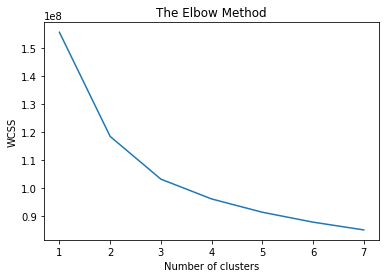

Time spent for training: 1471


In [4]:
# Perform multiple iterations of K-means and evaluate
start = time.time()

wcss = []
for i in range(1, 8):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 11)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 8), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

end = time.time()
print('Time spent for training: {}'.format(round(end-start)))
    

Clusters Models with K @ 3 and 4 seem to be the best based on this plot. To be thorough we will calculate Slihoutte Scores and Silhoutte Plots to make the most informed decision.

#### - <font color=purple>Silhoutte and Calinksi-Harabasz Scores</font> -

For n_clusters = 2
The average silhouette_score is : 0.43169860501134855
The calinski_harabasz_score is : 217267.6558588494

Time spent for training: 12837
For n_clusters = 3
The average silhouette_score is : 0.2514512370431118
The calinski_harabasz_score is : 175770.79082787898

Time spent for training: 12647
For n_clusters = 4
The average silhouette_score is : 0.1940957562621711
The calinski_harabasz_score is : 142732.85425750728

Time spent for training: 12598
For n_clusters = 5
The average silhouette_score is : 0.13474473798261344
The calinski_harabasz_score is : 117387.64509812451

Time spent for training: 12554
For n_clusters = 6
The average silhouette_score is : 0.20340973198627693
The calinski_harabasz_score is : 95597.13536554413

Time spent for training: 13164
For n_clusters = 7
The average silhouette_score is : 0.16410870864431212
The calinski_harabasz_score is : 88940.14089116464

Time spent for training: 13733


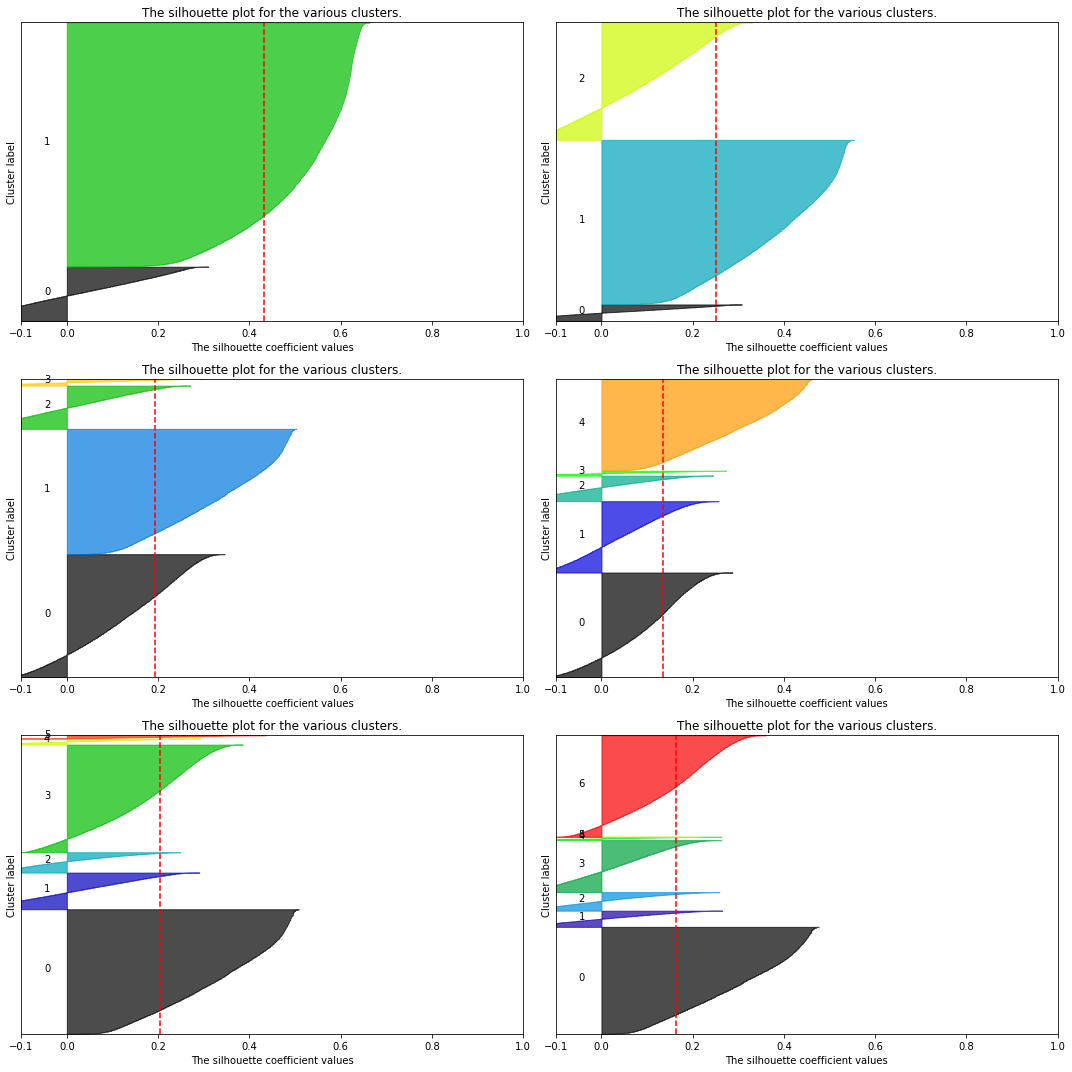

In [15]:
import time
plt.figure(figsize=(15,15))
for i, n_clusters in enumerate([2,3,4,5,6,7]):
    start = time.time()
    ## Cluster Calculation ##

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    kmeans = KMeans(featuresCol='features_scaled',
                    initMode='k-means||').setK(n_clusters).setSeed(11)

    # Create pipeline object
    kmeans = Pipeline(stages=[assembler,scaler,kmeans])

    ## Cluster Evaluation ##

    # Fit to DRV_January
    model = kmeans.fit(DRV_Jan2016)

    # Make predictions
    predictions = model.transform(DRV_Jan2016)

    # Make Cluster Labels
    cluster_labels = predictions.select('prediction').toPandas().prediction

    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    ch_score = metrics.calinski_harabasz_score(X_scaled, cluster_labels)  
    
    print("For n_clusters =", n_clusters)
    print("The average silhouette_score is :", silhouette_avg)
    print("The calinski_harabasz_score is :", ch_score)
    print('')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    ## Cluster Visualization ##

    # Create a subplot with 1 row and 2 columns
    plt.subplot(3,2,i+1)

    # Set plot limits to capture silhouette coefficient range of -0.1, 1 
    plt.xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    end = time.time()
    print('Time spent for training: {}'.format(round(end-start)))
    
plt.tight_layout()
plt.show()

After taking into consideration the WCSS Plot, Silhoutte Scores, and Silhoutte Plot, ***k = 4*** seems to be the optimal result. The 3-cluster model seemed to group two clusters together. In an attempt to improve upon ***k = 4*** model, we will run an ANOVA analysis for each feature and remove all features that are insignificant. We will then re-run our cluster model on the significant feature only to see if we can improve on this.

### - <font color=blue>Cluster Model #2: Removing Insignificant Features</font> -

#### - <font color=purple>Eliminate Insignificant Features</font> -

In [33]:
# Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
kmeans = KMeans(featuresCol='features_scaled',
                initMode='k-means||').setK(4).setSeed(11)

# Create pipeline object
kmeans = Pipeline(stages=[assembler,scaler,kmeans])

## Cluster Evaluation ##

# Fit to DRV_January
model = kmeans.fit(DRV_Jan2016)

# Make predictions
predictions = model.transform(DRV_Jan2016)

# Create Pandas DF of msno and cluster labels, export to csv
df = predictions[['msno','prediction']].toPandas()
df.to_csv('cluster labels')

In [34]:
# Add cluster labels to main DF
DRV_Jan2016x = pd.merge(DRV_Jan2016x, df, on='msno')

In [39]:
# Conduct One-Way ANOVA on All Features split by Cluster Label.
# The null hypothesis (H0) is that there is no difference between the groups and equality between means.
# The alternative hypothesis (H1) is that there is a difference between the means and groups.

# Create Datframe to Populate with ANOVA Results
anova_results = pd.DataFrame(columns=['Feature','t-Stat','pvalue'])

# ANOVA loop
for feature in cont_feats:
    # Conduct ANOVA test on each feature split on their respective clusters
    x = stats.f_oneway(DRV_Jan2016x[DRV_Jan2016x['prediction'] == 0][feature],
                   DRV_Jan2016x[DRV_Jan2016x['prediction'] == 1][feature],
                   DRV_Jan2016x[DRV_Jan2016x['prediction'] == 2][feature],
                   DRV_Jan2016x[DRV_Jan2016x['prediction'] == 3][feature])
    
    # Add results to anova_results df
    anova_results = anova_results.append({'Feature':f'{feature}','t-Stat':f'{x.statistic}','pvalue':f'{x.pvalue:1.4f}'}, ignore_index=True)

In [41]:
anova_results.sort_values('pvalue', axis=0, ascending=False).head(10)

Feature              t-Stat  pvalue
91          total_secs_last_120  0.6821752094805265  0.5628
92      total_secs_last_120_AVG  0.6821752094805263  0.5628
219  DIFSTD_songs50_30_45_45_60  2.8110158615206395  0.0379
7                    total_secs   5.863437387908023  0.0005
0             payment_plan_days   310.5936372222283  0.0000
153            AVG_logins_30_45   329907.5905976361  0.0000
143             SUM_songs_30_45   462968.6556364203  0.0000
144             AVG_songs_30_45  462968.65563642036  0.0000
145             STD_songs_30_45   99499.42638203138  0.0000
146              SUM_secs_30_45   226835.3387494349  0.0000

In [8]:
# Create list of all significant features
cont_feats_sig = cont_feats.copy()
cont_feats_sig.remove('total_secs_last_120')
cont_feats_sig.remove('total_secs_last_120_AVG')
cont_feats_sig.remove('DIFSTD_songs50_30_45_45_60')

#### - <font color=purple>*Vector Assembler*</font> -

In [9]:
# Create master list of feature names for model
final_features = cont_feats_sig

In [10]:
# Specify the numeric features we will be transforming, and the name of the resulting output feature
assembler = VectorAssembler(
    inputCols= final_features,
    outputCol='features')

#### - <font color=purple>*Feature Scaling*</font> - 

In [11]:
# Scale all features into our final output features
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol='features', 
                        outputCol='features_scaled',
                        withStd=True, withMean=False)

#### - <font color=purple>Silhoutte and Calinksi-Harabasz Scores</font> -

In [46]:
import time
n_clusters = 4
start = time.time()
## Cluster Calculation ##

# Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
kmeans = KMeans(featuresCol='features_scaled',
                initMode='k-means||').setK(n_clusters).setSeed(11)

# Create pipeline object
kmeans = Pipeline(stages=[assembler,scaler,kmeans])

## Cluster Evaluation ##

# Fit to DRV_January
model = kmeans.fit(DRV_Jan2016)

# Make predictions
predictions = model.transform(DRV_Jan2016)

# Make Cluster Labels
cluster_labels = predictions.select('prediction').toPandas().prediction

# Calculate silhouette scores
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
ch_score = metrics.calinski_harabasz_score(X_scaled, cluster_labels)  

print("For n_clusters =", n_clusters)
print("The average silhouette_score is :", silhouette_avg)
print("The calinski_harabasz_score is :", ch_score)
print('')

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
end = time.time()
print('Time spent for training: {}'.format(round(end-start)))

For n_clusters = 4
The average silhouette_score is : 0.19409669706779936
The calinski_harabasz_score is : 142732.85767410247

Time spent for training: 16367


#### - <font color=purple>*Cluster Visualization*</font> - 

Time spent for training: 0


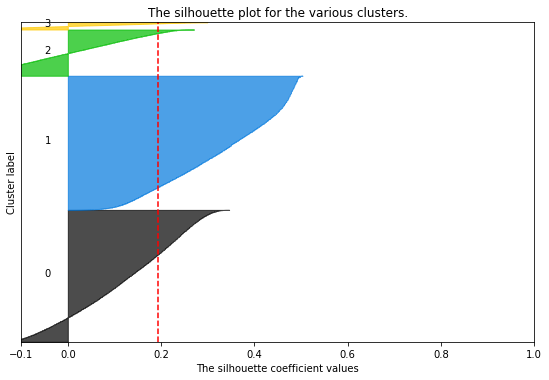

In [48]:
i = 0

# Create a Plot
start = time.time()
plt.figure(figsize=(15,15))
plt.subplot(3,2,i+1)

# Set plot limits to capture silhouette coefficient range of -0.1, 1 
plt.xlim([-0.1, 1])

# The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
plt.ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
end = time.time()
print('Time spent for training: {}'.format(round(end-start)))

plt.tight_layout()
plt.show()

#### - <font color=purple>*Transform on DRV_Feb2016 and Export*</font> -

In [12]:
import time
n_clusters = 4
start = time.time()
## Cluster Calculation ##

# Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
kmeans = KMeans(featuresCol='features_scaled',
                initMode='k-means||').setK(n_clusters).setSeed(11)

# Create pipeline object
kmeans = Pipeline(stages=[assembler,scaler,kmeans])

## Cluster Evaluation ##

# Fit to DRV_January
model = kmeans.fit(DRV_Jan2016)

# Make predictions
predictions_feb = model.transform(DRV_Feb2016)

end = time.time()
print('Time spent for training: {}'.format(round(end-start)))

Time spent for training: 132
